# Задача 3. Сравнение методов классификации

## Список задач
1. Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
2. Взять данные для предсказания заболеваний сердца.
3. Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
4. Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
5. При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
6. Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
7. Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
8. Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
9. Реализовать еще один из методов классификации и добавить его в сравнение.
10. Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [3]:
from typing import Union

import numpy as np
from numpy.typing import NDArray
import pandas as pd
import polars as pl

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

import optuna

c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1/9. Самостоятельно реализовать два метода классификации, с возможностью настройки гиперпараметров.
Реализую дерево решений (Decision Tree) по алгоритму CART и метод опорных векторов (Support Vector Machine)

## Дерево решений

In [ ]:
class Metrics:
    """
    Класс метрик качества для задач классификации и кластеризации
    """
    
    @staticmethod
    def gini(y: np.ndarray) -> float:
        """
        Вычисляем коэффициент Gini для вектора целевых переменных

        Параметры:
            y (np.ndarray): Одномерный массив (целочисленный вектор)

        Возвращает:
            float: Значение коэффициента Gini
        """
        count_targets = len(y)
        if count_targets == 0:
            return 0.0

        _, count_each_target = np.unique(y, return_counts=True)
        probabilities = count_each_target / count_targets
        return 1 - np.sum(probabilities ** 2)

    @staticmethod
    def gini_split(left_y: np.ndarray, right_y: np.ndarray) -> float:
        """
        Вычисляем коэффициент Gini для узла при выбранном пороге

        Параметры:
            left_y: Массив целевых переменных для левой ветви.
            right_y: Массив целевых переменных для правой ветви.

        Возвращает:
            float: Взвешенное значение Gini для разбиения.
        """
        count_objects = len(left_y) + len(right_y)

        left_leaf_loss = Metrics.gini(left_y)
        right_leaf_loss = Metrics.gini(right_y)
        weighted_gini = ((len(left_y) / count_objects) * left_leaf_loss) + \
                        ((len(right_y) / count_objects) * right_leaf_loss)

        return weighted_gini, left_leaf_loss, right_leaf_loss

class Node:
    """
    Класс узла дерева

    Параметры:
        X: подвыборка признаков в узле
        y: подвыборка целевых переменных в узле
    """

    def __init__(self, X: pl.DataFrame = None, y: np.ndarray = None, depth: int = 0):
        self.left_node = None
        self.right_node = None

        self.X = X
        self.y = y

        self.feature = None
        self.threshold = None

        self.score = Metrics.gini(y) if y is not None else None

        self.depth = depth

    def create_child_nodes(self, metric='Gini', max_depth=3, min_samples_split=2):
        """
        Функция создания дочерних узлов, присвоение им выборки соответствующих целевых переменных

        Параметры:
            metric: выбранная метрика качества
            max_depth: максимальная глубина дерева
            min_samples_split: минимальное количество образцов для разделения

        Возвращает:
            None
        """
        if self.depth >= max_depth or len(self.y) < min_samples_split or self.score == 0:
            return

        best_feature, best_threshold, best_score, left_indices, right_indices = self.__choose_best_split(metric)
        if best_feature is None:
            return

        self.feature = best_feature
        self.threshold = best_threshold

        X_left = self.X[left_indices]
        y_left = self.y[left_indices]
        X_right = self.X[right_indices]
        y_right = self.y[right_indices]

        self.left_node = Node(X_left, y_left, depth=self.depth + 1)
        self.right_node = Node(X_right, y_right, depth=self.depth + 1)

        self.left_node.create_child_nodes(metric, max_depth, min_samples_split)
        self.right_node.create_child_nodes(metric, max_depth, min_samples_split)

    def __choose_best_split(self, metric='Gini'):
        """
        Вычисляет оптимальный признак и порог для узла, исходя из выбранной метрики

        Возвращает:
            best_feature, best_threshold, best_score, left_indices, right_indices
        """
        best_feature = None
        best_threshold = None
        best_score = np.inf
        best_left_indices = None
        best_right_indices = None

        features = self.X.columns

        for feature in features:
            X_column = self.X[feature].to_numpy()
            thresholds, scores, left_indices_list, right_indices_list = self.__find_thresholds(X_column, self.y, metric)

            if len(scores) == 0:
                continue

            min_score_index = np.argmin(scores)
            score = scores[min_score_index]
            if score < best_score:
                best_score = score
                best_threshold = thresholds[min_score_index]
                best_feature = feature
                best_left_indices = left_indices_list[min_score_index]
                best_right_indices = right_indices_list[min_score_index]

        return best_feature, best_threshold, best_score, best_left_indices, best_right_indices

    def __find_thresholds(self, X_column: np.ndarray, y: np.ndarray, metric='Gini'):
        """
        Находит все возможные пороги для признака и вычисляет метрику для каждого

        Возвращает:
            thresholds, scores, left_indices_list, right_indices_list
        """
        thresholds = []
        scores = []
        left_indices_list = []
        right_indices_list = []

        sorted_indices = np.argsort(X_column)
        X_sorted = X_column[sorted_indices]
        y_sorted = y[sorted_indices]

        unique_values = np.unique(X_sorted)
        if len(unique_values) == 1:
            return thresholds, scores, left_indices_list, right_indices_list

        for i in range(1, len(X_sorted)):
            if X_sorted[i] == X_sorted[i - 1]:
                continue  # пропускаем повторяющиеся значения

            threshold = (X_sorted[i] + X_sorted[i - 1]) / 2

            left_indices = sorted_indices[:i]
            right_indices = sorted_indices[i:]

            left_y = y[left_indices]
            right_y = y[right_indices]

            if metric == 'Gini':
                score, _, _ = Metrics.gini_split(left_y, right_y)
            else:
                raise ValueError(f"Неизвестная метрика: {metric}")

            thresholds.append(threshold)
            scores.append(score)
            left_indices_list.append(left_indices)
            right_indices_list.append(right_indices)

        return thresholds, scores, left_indices_list, right_indices_list

    def majority_class(self):
        """
        Возвращает класс большинства в листе.
        """
        values, counts = np.unique(self.y, return_counts=True)
        return values[np.argmax(counts)]

class MyDecisionTree:
    """
    Класс решающего дерева, реализованного по алгоритму CART

    Параметры:
        max_depth: максимальная глубина дерева
        metric: метрика качества
    """
    
    def __init__(self, max_depth: int = 3, metric: str = 'Gini', min_samples_split: int = 2):
        self.max_depth = max_depth
        self.metric = metric
        self.min_samples_split = min_samples_split
        self.root = None
    
    def encode_categorical_features(self, X: pl.DataFrame):
        """
        Метод кодирования категориальных переменных с помощью One-Hot Encoding

        Параметры:
            X: датафрейм данных

        Возвращает:
            pl.DataFrame: датафрейм данных с закодированными категориальными переменными
        """
        categorical_features = [feature for feature, dtype in X.schema.items() if dtype == pl.Utf8]
        if len(categorical_features) == 0:
            return X

        X_encoded = X.to_pandas()
        X_encoded = pd.get_dummies(X_encoded, columns=categorical_features)
        return pl.from_pandas(X_encoded)
    
    def fit(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame], y: np.ndarray):
        """
        Метод построения решающего дерева на основе данных

        Параметры:
            X: датафрейм данных
            y: вектор целевых переменных

        Возвращает:
            self
        """
        # Преобразование данных в pl.DataFrame
        if isinstance(X, pd.DataFrame):
            X = pl.from_pandas(X)
        elif isinstance(X, np.ndarray):
            X = pl.DataFrame(X)
        elif not isinstance(X, pl.DataFrame):
            raise ValueError("X должен быть pd.DataFrame, pl.DataFrame или np.ndarray")

        # Кодирование категориальных признаков
        X = self.encode_categorical_features(X)

        self.features = X.columns

        self.root = Node(X, y, depth=0)
        self.root.create_child_nodes(metric=self.metric, max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        return self
    
    def predict(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame]) -> np.ndarray:
        """
        Метод предсказания целевой метки объектов

        Параметры:
            X: датафрейм данных

        Возвращает:
            np.ndarray: список предсказанных целевых меток
        """
        # Преобразование данных в pl.DataFrame
        if isinstance(X, pd.DataFrame):
            X = pl.from_pandas(X)
        elif isinstance(X, np.ndarray):
            #X = pl.DataFrame(X, columns=self.features)
            X = pl.DataFrame(X)
        elif not isinstance(X, pl.DataFrame):
            raise ValueError("X должен быть pd.DataFrame, pl.DataFrame или np.ndarray")

        # Кодирование категориальных признаков
        X = self.encode_categorical_features(X)

        y_pred = []
        
        for row_idx in range(X.height):
            current_node = self.root
            while current_node.left_node is not None and current_node.right_node is not None:
                if current_node.feature not in X.columns:
                    break
                value = X[current_node.feature][row_idx]
                if value <= current_node.threshold:
                    current_node = current_node.left_node
                else:
                    current_node = current_node.right_node
            y_pred.append(current_node.majority_class())
    
        return np.array(y_pred)
    
    def pruning(self, X_val: Union[np.ndarray, pd.DataFrame, pl.DataFrame], y_val: np.ndarray, alpha: float = 0.0):
        """
        Обрезка дерева (pruning) с использованием метода минимальной стоимости сложения (Cost-Complexity Pruning)

        Параметры:
            X_val: валидационные данные
            y_val: целевые метки для валидационных данных
            alpha (float): параметр сложности модели

        Возвращает:
            self
        """

        y_pred = self.predict(X_val)
        best_accuracy = np.mean(y_pred == y_val)
        best_tree = self.root

        def prune_node(node: Node):
            if node.left_node is None or node.right_node is None:
                return

            left_backup = node.left_node
            right_backup = node.right_node

            node.left_node = None
            node.right_node = None

            y_pred = self.predict(X_val)
            accuracy = np.mean(y_pred == y_val)

            if accuracy >= best_accuracy - alpha:
                best_accuracy = accuracy
                best_tree = self.root
            else:
                node.left_node = left_backup
                node.right_node = right_backup

                prune_node(node.left_node)
                prune_node(node.right_node)

        prune_node(self.root)
        self.root = best_tree
        return self

## Метод опорных векторов

In [41]:
class MyLinearSVM:
    """
    Класс метода опорных векторов, линейно разделяющего данные

    Параметры:
        X: датасет признаков
        y: вектор целевых меток
        С: коэффициент регуляризации
        kernel: ядро
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, C: float = 0.0):
        self.X = X
        self.y = y
    
        self.count_objects = self.X.shape[0]
        self.count_features = self.X.shape[1]

        self.C = C
        self.W = np.zeros(self.count_features)
        self.b = 0.0

    def __gradient_descent(self, threshold: float = 1e-3, lr: float = 1e-2, max_iter: int = 10000):
        """
        Подбор параметров линейно разделяющего SVM методом градиентного спуска

        Параметры:
            threshold: порог, если меньше которого будет изменение, то алгоритм остановится
            lr: скорость обучения
            max_iter: максимальное количество итераций

        Возвращает:
            self
        """
        for step in range(max_iter):
            hinge_loss_gradient = 1 - self.y * (self.W.dot(self.X.T) + self.b)
            mask = hinge_loss_gradient > 0

            dW = self.W - self.C * np.sum((self.y[mask][:, None] * self.X[mask, :]), axis=0)
            db = -self.C * np.sum(self.y[mask])

            self.W -= lr * dW
            self.b -= lr * db
            
            # Условие выхода
            if np.linalg.norm(dW) < threshold and abs(db) < threshold:
                break
            
        return self

    def fit(self):
        """
        Обучение классификатора SVM

        Возвращает:
            self
        """
        self.__gradient_descent()
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame]):
        if isinstance(X, (pl.DataFrame, pd.DataFrame)):
            X = X.to_numpy()

        if self.W is None or self.b is None:
            raise ValueError("Модель ещё не обучена. Сначала вызовите метод `fit`.")

        decision = np.dot(X, self.W) + self.b
        # Применяем функцию знака
        return np.sign(decision)

class MyNonlinearSVM:
    """
    Класс метода опорных вектор, нелинейно разделяющего данные

    Параметры:
        X: датасет признаков
        y: вектор целевых меток
        С: коэффициент регуляризации
        gamma: гиперпараметр, отвечающий за ширину ядра
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, C: float = 1.0, gamma: float = 0.1):
        self.X = X
        self.y = y

        self.count_objects = self.X.shape[0]
        self.count_features = self.X.shape[1]

        self.gamma = gamma
        self.C = C

    def rbf_kernel(self, x1, x2):
        """
        Вычисление RBF ядра между двумя векторами.
        """
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def compute_kernel_matrix(self):
        """
        Вычисление матрицы ядра.
        """
        K = np.zeros((self.count_objects, self.count_objects))
        for i in range(self.count_objects):
            for j in range(self.count_objects):
                K[i, j] = self.rbf_kernel(self.X[i], self.X[j])
        return K

    def fit(self):
        """
        Обучение SVM с использованием RBF ядра.
        """
        K = self.compute_kernel_matrix()

        def objective(alpha):
            return 0.5 * np.sum(
                alpha[i] * alpha[j] * self.y[i] * self.y[j] * K[i, j]
                for i in range(self.count_objects)
                for j in range(self.count_objects)
            ) - np.sum(alpha)

        constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, self.y)}

        bounds = [(0, self.C) for _ in range(self.count_objects)]

        result = minimize(
            fun=objective,
            x0=np.zeros(self.count_objects),
            bounds=bounds,
            constraints=constraints
        )

        if not result.success:
            raise ValueError("Оптимизация не сошлась: " + result.message)

        self.alpha = result.x
        self.b = self.calculate_bias(K)

        return self

    def calculate_bias(self, K):
        """
        Вычисление смещения b.
        """
        support_vector_indices = np.where((self.alpha > 1e-5) & (self.alpha < self.C))[0]
        b_sum = 0
        for i in support_vector_indices:
            b_sum += self.y[i] - np.sum(
                self.alpha[j] * self.y[j] * K[i, j]
                for j in range(self.count_objects)
            )
        return b_sum / len(support_vector_indices)

    def predict(self, X_test):
        """
        Прогнозирование меток для тестовых данных.
        """
        K_test = np.exp(-self.gamma * cdist(X_test, self.X, 'sqeuclidean'))
        
        decision = (K_test @ (self.alpha * self.y)) + self.b
        
        y_pred = np.sign(decision)
        y_pred[y_pred == -1] = 0
        return y_pred

class MySVM:
    """
    Класс метода опорных векторов, линейно разделяющего данные

    Параметры:
        X: датасет признаков
        y: вектор целевых меток
        С: коэффициент регуляризации
        gamma: гиперпараметр, отвечающий за ширину ядра
        kernel: ядро
    """
    def __init__(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame], 
                 y: Union[np.ndarray, pd.DataFrame, pl.DataFrame],
                 C: float = 0.0, kernel: str = 'rbf',
                 gamma: float = 1):
        if isinstance(X, (pl.DataFrame, pd.DataFrame)):
            X = X.to_numpy()
        self.X = X

        if isinstance(y, (pl.DataFrame, pd.DataFrame, pl.Series, pd.Series)):
            y = y.to_numpy()
        self.y = y
    
        self.count_objects = self.X.shape[0]
        self.count_features = self.X.shape[1]

        self.gamma = gamma
        self.C = C
        
        self.kernel = kernel
        self.svm = None

    def __choose_fit_pipeline(self):
        if self.kernel == 'linear':
            self.svm = MyLinearSVM(self.X, self.y, C=self.C).fit()
        elif self.kernel == 'rbf':
            self.svm = MyNonlinearSVM(self.X, self.y, C=self.C, gamma=self.gamma).fit()
        else:
            raise ValueError("Несуществующее ядро")
        
        return self

    def fit(self):
        """
        Обучение классификатора SVM

        Возвращает:
            self
        """
        self.__choose_fit_pipeline()
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame]):
        """
        Предсказание класса объекта

        Параметры:
            X: датафрейм объектов

        Возвращает:
            np.array: массив предсказанных целевых меток
        """
        if isinstance(X, (pl.DataFrame, pd.DataFrame)):
            X = X.to_numpy()

        if self.svm is None:
            raise ValueError("Модель ещё не обучена. Сначала вызовите метод `fit`.")

        return self.svm.predict(X)

# 2. Загрузка данных о заболевании сердца

Этот набор данных датируется 1988 годом и состоит из четырех баз данных: Cleveland, Hungary, Switzerland и Long Beach V. Он содержит 76 атрибутов, включая предсказанный атрибут, но все опубликованные эксперименты относятся к использованию подмножества из 14 из них. Поле "target" указывает на наличие у пациента сердечно-сосудистых заболеваний. Оно имеет целое значение 0 = отсутствие заболевания и 1 = болезнь.

Данные довольно специализированны и не каждый атрибут поддаётся полноценной интерпретации без экспертных знаний в области кардиологии.

1. age - возраст
2. sex - пол
3. chest pain type (4 values) - тип боли в груди
4. resting blood pressure - кровяное давление в состоянии покоя
5. serum cholestoral in mg/dl - уровень холестерина в сыворотке крови в мг/дл
6. fasting blood sugar > 120 mg/dl - уровень сахара в крови натощак > 120 мг/дл
7. resting electrocardiographic results (values 0,1,2) - результаты электрокардиографии в состоянии покоя (значения 0,1,2)
8. maximum heart rate achieved - достигнута максимальная частота сердечных сокращений
9. exercise induced angina - стенокардия, вызванная физической нагрузкой
10. oldpeak = ST depression induced by exercise relative to rest - олдпик = депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом.
11. the slope of the peak exercise ST segment - наклон сегмента ST пикового упражнения
12. number of major vessels (0-3) colored by flourosopy - количество крупных сосудов (0-3), окрашенных методом флуороскопии
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect - значение: 0 = нормальный; 1 = исправленный дефект; 2 = устраняемый дефект.

In [6]:
df = pl.read_csv('heart.csv')

In [7]:
df.unique()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64
47,1,2,108,243,0,1,152,0,0.0,2,0,2,0
53,1,0,123,282,0,1,95,1,2.0,1,2,3,0
62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
57,1,0,110,201,0,1,126,1,1.5,1,0,1,1
58,1,0,128,259,0,0,130,1,3.0,1,2,3,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
59,1,0,170,326,0,0,140,1,3.4,0,0,3,0
57,1,0,132,207,0,1,168,1,0.0,2,0,3,1
64,0,0,180,325,0,1,154,1,0.0,2,0,2,1


Оказывается, 70% датасета - дубликаты. Допустим.. Придётся удалить

In [8]:
df = df.unique(maintain_order=True)

targets = df['target']
features = df.drop('target')

# 3, 4, 5. EDA, Data Cleaning, convert categorical

In [9]:
features = features.unique(maintain_order=True)

In [10]:
features.describe()

statistic,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",54.42053,0.682119,0.963576,131.602649,246.5,0.149007,0.52649,149.569536,0.327815,1.043046,1.397351,0.718543,2.31457
"""std""",9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026
"""min""",29.0,0.0,0.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0
"""25%""",48.0,0.0,0.0,120.0,211.0,0.0,0.0,133.0,0.0,0.0,1.0,0.0,2.0
"""50%""",56.0,1.0,1.0,130.0,241.0,0.0,1.0,153.0,0.0,0.8,1.0,0.0,2.0
"""75%""",61.0,1.0,2.0,140.0,275.0,0.0,1.0,166.0,1.0,1.6,2.0,1.0,3.0
"""max""",77.0,1.0,3.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,2.0,4.0,3.0


Каких-то экстремальных значений не наблюдается.

Ради приличия посмотрим на корреляцию, хотя и решающие деревья, и и SVM с нелинейным ядром не так сильно подвержены проблеме мультиколлианеарных признаков, как линейные модели.

<Axes: >

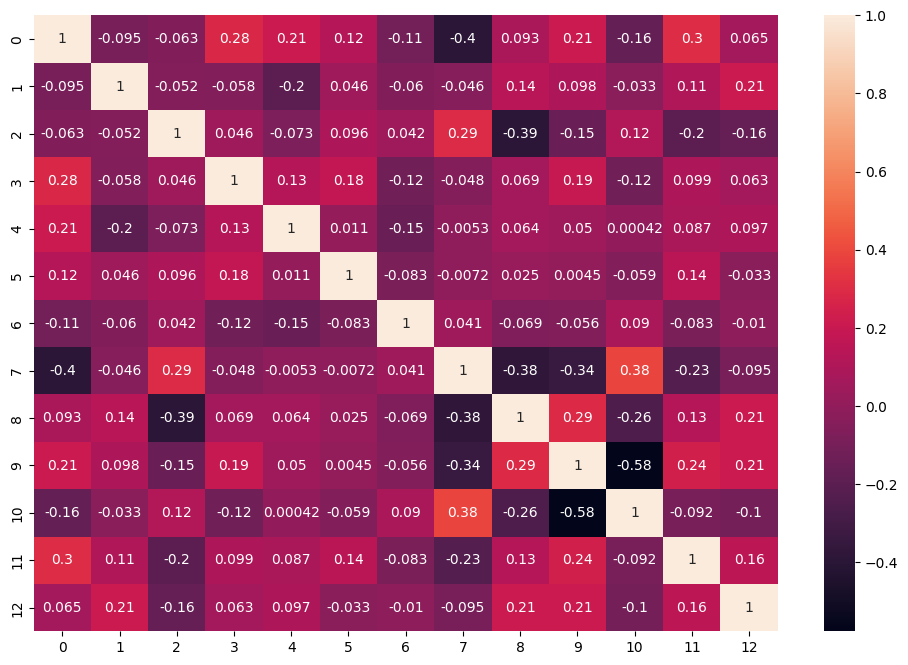

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(features.corr(), annot=True)

Максимальная корреляция по модулю = -0.58. Всё не так плохо

Также, чтобы избежать поиска "несуществующих" зависимостей между данными, перекодируем категориальные переменные из метода LabelEncoder с помощью метода OneHotEncoding

In [12]:
features = features.with_columns(
    features.select(["cp", "thal"]).to_dummies()
)

features = features.drop(["cp_3", "thal_3", "cp", "thal"])

Проверем датасет на дисбаланс классов. Ведь нужно учитывать, что только дерево решений нормально работает при наличии доминирующего класса.

<Axes: ylabel='Count'>

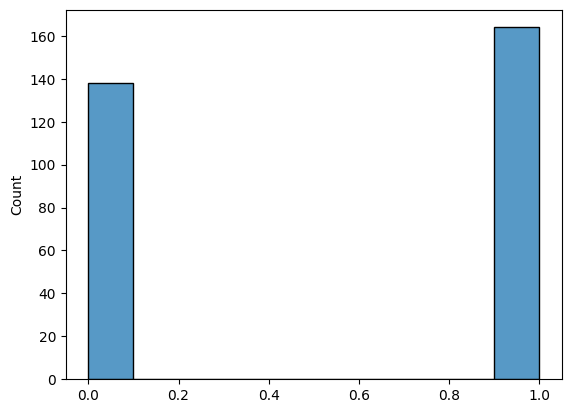

In [13]:
sns.histplot(targets)

# 6. Scale data, CV, подбор гиперпараметров, проверка собственной имплементации

Т.к. у нас задача, направленная на выявление болезни, нам очень важно получать максимальное количество правильно поставленных болезней при общем количестве больных. Если окажутся ложнобольные, это не так страшно.

Поэтому используем Recall (P.S: я делал этот пункт после 7-го, где проверяются библиотечные методы. И было принято решение сменить Recall на ROC-AUC. Мотивация решения будет объяснена дальше)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, shuffle=True, stratify=targets)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 6.1 SVM

In [35]:
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'rbf'])
    C = trial.suggest_float("C", 0.001, 10.0, step=1)
    gamma = trial.suggest_float("gamma", 0.001, 5, step=0.1)

    clf = MySVM(
            X=X_train,
            y=y_train,
            kernel = kernel,
            C=C, 
            gamma=gamma
    )
    
    clf.fit()

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)

    return score

study = optuna.create_study(study_name='SVC_study', direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 17:28:37,186] A new study created in memory with name: SVC_study
c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.001, 5] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.001, 4.901].
  warnings.warn(
[I 2024-11-21 17:28:37,235] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'linear', 'C': 6.001, 'gamma': 3.701}. Best is trial 0 with value: 0.5.
c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.001, 10.0] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 9.001].
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.001, 5] and step=0.1, but the range is not divisible by `step`. It 

Best trial:
  Values:  [0.6257839721254355]
  Params: 
    kernel: rbf
    C: 7.001
    gamma: 0.7010000000000001


In [ ]:
svm = MySVM(X_train, y_train, C=7.0, kernel='rbf', gamma=0.7)
svm.fit()

y_pred = svm.predict(X_test)
roc_auc_score(y_test, y_pred)

C:\Users\Maksim\AppData\Local\Temp\ipykernel_8288\3684780346.py:114: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return 0.5 * np.sum(
C:\Users\Maksim\AppData\Local\Temp\ipykernel_8288\3684780346.py:146: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  b_sum += self.y[i] - np.sum(


np.float64(0.6421602787456446)

              precision    recall  f1-score   support

           0       0.55      0.94      0.69        35
           1       0.88      0.34      0.49        41

    accuracy                           0.62        76
   macro avg       0.71      0.64      0.59        76
weighted avg       0.73      0.62      0.58        76



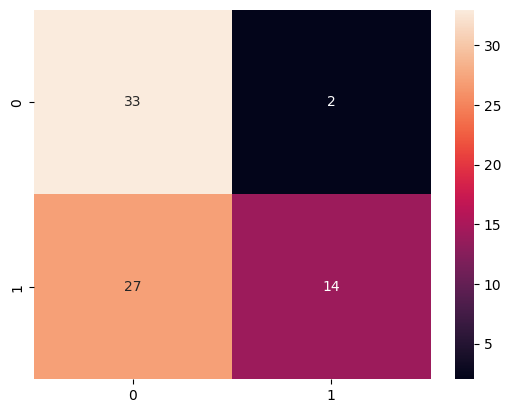

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

Ну прямо плохо..

## 6.2 DecisionTree

In [49]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 4, step=1)

    clf = MyDecisionTree(
            max_depth=max_depth,
            min_samples_split=min_samples_split
        )
    
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)
    return score

study = optuna.create_study(study_name='DecisionTree_study', direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 17:45:34,722] A new study created in memory with name: DecisionTree_study
[I 2024-11-21 17:45:35,072] Trial 0 finished with value: 0.7351916376306621 and parameters: {'max_depth': 5, 'min_samples_split': 4}. Best is trial 0 with value: 0.7351916376306621.
[I 2024-11-21 17:45:35,441] Trial 1 finished with value: 0.7006968641114982 and parameters: {'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.7351916376306621.
[I 2024-11-21 17:45:35,813] Trial 2 finished with value: 0.6986062717770035 and parameters: {'max_depth': 8, 'min_samples_split': 2}. Best is trial 0 with value: 0.7351916376306621.
[I 2024-11-21 17:45:36,188] Trial 3 finished with value: 0.6986062717770035 and parameters: {'max_depth': 8, 'min_samples_split': 2}. Best is trial 0 with value: 0.7351916376306621.
[I 2024-11-21 17:45:36,574] Trial 4 finished with value: 0.686411149825784 and parameters: {'max_depth': 9, 'min_samples_split': 2}. Best is trial 0 with value: 0.7351916376306621.
[I 

Best trial:
  Values:  [0.7759581881533102]
  Params: 
    max_depth: 3
    min_samples_split: 4


In [56]:
tree = MyDecisionTree(max_depth=3, min_samples_split=4)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
roc_auc_score(y_test, y_pred)

np.float64(0.7759581881533102)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.80      0.78      0.79        41

    accuracy                           0.78        76
   macro avg       0.78      0.78      0.78        76
weighted avg       0.78      0.78      0.78        76



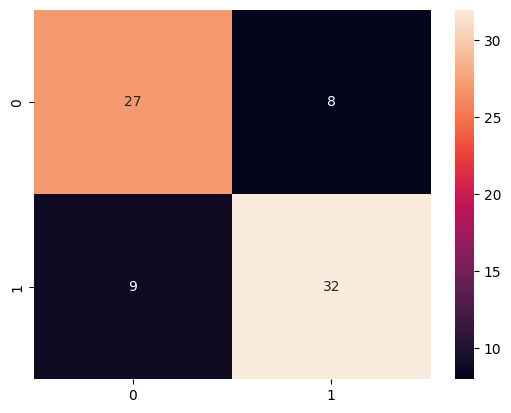

In [57]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

Ну вот решающее дерево уже кратно лучше, чем SVM

# 7. Проверка библиотечных методов

## 7.1 Logistic Regression

In [224]:
scores = {}

In [ ]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    penalty = trial.suggest_categorical("penalty", ['l1', 'l2', 'elasticnet', 'none'])
    C = trial.suggest_float("C", 1e-5, 10.0, step=5e-2)
    l1_ratio = 0
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 1e-5, 1.0, step=5e-3)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            penalty=penalty, 
            C=C, 
            l1_ratio=l1_ratio, 
            solver='saga', 
            max_iter=10000
        ))
    ])
    score = cross_val_score(clf, features, targets, n_jobs=-1, cv=stratified_cv, scoring='recall').mean()

    return score

study = optuna.create_study(study_name='logreg_study', direction='maximize')
study.optimize(objective, n_trials=300)

[I 2024-11-21 02:41:50,751] A new study created in memory with name: logreg_study


C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.05, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.95001].
  warnings.warn(
[I 2024-11-21 02:41:58,217] Trial 0 finished with value: 0.8794117647058824 and parameters: {'penalty': 'l2', 'C': 7.95001}. Best is trial 0 with value: 0.8794117647058824.
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.05, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.95001].
  warnings.warn(
[I 2024-11-21 02:41:58,352] Trial 1 finished with value: 0.8794117647058824 and parameters: {'penalty': 'none', 'C': 7.50001}. Best is trial 0 with value: 0.8794117647058824.
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribut

In [218]:
print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Values:  [1.0]
  Params: 
    penalty: l2
    C: 1e-05


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.54      1.00      0.70        41

    accuracy                           0.54        76
   macro avg       0.27      0.50      0.35        76
weighted avg       0.29      0.54      0.38        76



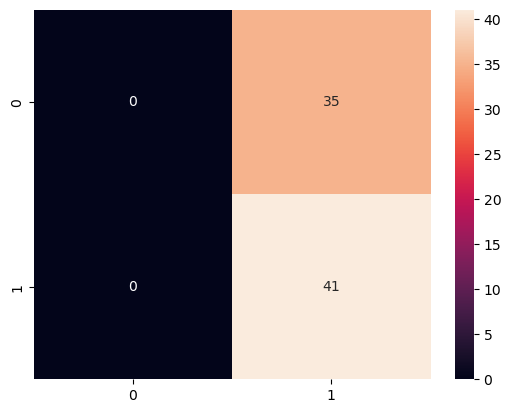

In [221]:
clf = LogisticRegression(penalty='l2', C=1e-5, solver='saga').fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

Результаты, конечно, бред. Модель подогналась под Recall, просто помечая всех - больными. Но это, конечно, неправильно. Можёт все же дальше буду оптимизировать roc_auc.

In [225]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    penalty = trial.suggest_categorical("penalty", ['l1', 'l2', 'elasticnet', 'none'])
    C = trial.suggest_float("C", 1e-5, 10.0, step=5e-2)
    l1_ratio = 0
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 1e-5, 1.0, step=5e-3)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            penalty=penalty, 
            C=C, 
            l1_ratio=l1_ratio, 
            solver='saga', 
            max_iter=10000
        ))
    ])
    score = cross_val_score(clf, features, targets, n_jobs=-1, cv=stratified_cv, scoring='roc_auc').mean()

    return score

study = optuna.create_study(study_name='logreg_study', direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 02:44:51,931] A new study created in memory with name: logreg_study
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.05, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.95001].
  warnings.warn(
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 1.0] and step=0.005, but the range is not divisible by `step`. It will be replaced by [1e-05, 0.99501].
  warnings.warn(
[I 2024-11-21 02:44:52,053] Trial 0 finished with value: 0.9034603264382677 and parameters: {'penalty': 'elasticnet', 'C': 4.550009999999999, 'l1_ratio': 0.54501}. Best is trial 0 with value: 0.9034603264382677.
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.05, but t

Best trial:
  Values:  [0.908330639948287]
  Params: 
    penalty: l1
    C: 1.1000100000000002


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.83      0.93      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



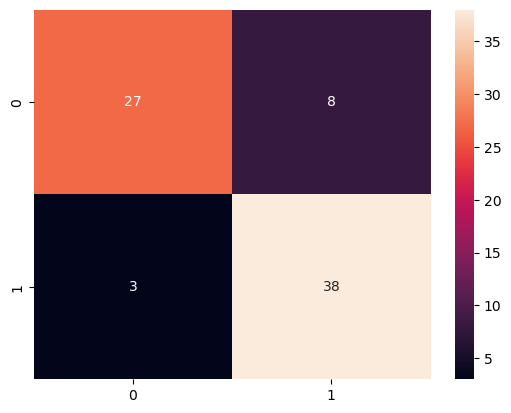

In [226]:
clf = LogisticRegression(penalty='l1', C=1.1, solver='saga').fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

In [227]:
38/41

0.926829268292683

In [245]:
scores['logreg'] = classification_report(y_test, y_pred)

Угадываем 92% - для такой модели очень неплохо, для медицины - катастрофа)

## 7.2 SVM

In [228]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf'])
    degree = 1
    coef0 = 0.0
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5, step=1)
        coef0 = trial.suggest_float('coef0', 0.0, 1.0, step = 0.1)

    C = trial.suggest_float("C", 1e-5, 10.0, step=5e-2)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC( 
            C = C, 
            degree = degree, 
            coef0 = coef0,
            max_iter = -1
        ))
    ])
    score = cross_val_score(clf, features, targets, cv=stratified_cv, n_jobs=-1, scoring='roc_auc').mean()

    return score

study = optuna.create_study(study_name='SVC_study', direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 02:46:12,310] A new study created in memory with name: SVC_study
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.05, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.95001].
  warnings.warn(
[I 2024-11-21 02:46:12,430] Trial 0 finished with value: 0.8975133322559794 and parameters: {'kernel': 'rbf', 'C': 1.05001}. Best is trial 0 with value: 0.8975133322559794.
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.05, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.95001].
  warnings.warn(
[I 2024-11-21 02:46:12,523] Trial 1 finished with value: 0.8842315772462832 and parameters: {'kernel': 'linear', 'C': 3.6500100000000004}. Best is trial 0 with value: 0.8975133322559794.
C:\Users\Maksim\AppData\Roa

Best trial:
  Values:  [0.9041430995475114]
  Params: 
    kernel: poly
    degree: 3
    coef0: 0.9
    C: 0.10001


              precision    recall  f1-score   support

           0       0.90      0.74      0.81        35
           1       0.81      0.93      0.86        41

    accuracy                           0.84        76
   macro avg       0.85      0.83      0.84        76
weighted avg       0.85      0.84      0.84        76



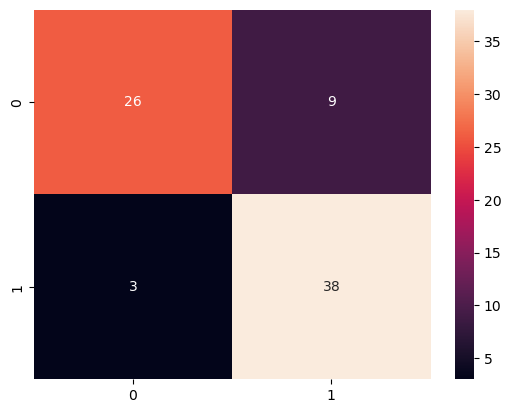

In [229]:
clf = SVC(kernel='linear', C=0.1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

In [230]:
scores['svm'] = classification_report(y_test, y_pred)

Результаты вцелом сходные с лог.регрессией.

## 7.3 KNN

In [231]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    n_neighbors = trial.suggest_int('n_neighbors', 1, 10, step=1)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier( 
            n_neighbors = n_neighbors, 
            weights = weights
        ))
    ])
    score = cross_val_score(clf, features, targets, cv=stratified_cv, n_jobs=-1, scoring='roc_auc').mean()

    return score

study = optuna.create_study(study_name='KNN_study', direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 02:47:47,439] A new study created in memory with name: KNN_study
[I 2024-11-21 02:47:48,010] Trial 0 finished with value: 0.8907855930833872 and parameters: {'n_neighbors': 10, 'weights': 'uniform'}. Best is trial 0 with value: 0.8907855930833872.
[I 2024-11-21 02:47:48,116] Trial 1 finished with value: 0.8782270119586295 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 0 with value: 0.8907855930833872.
[I 2024-11-21 02:47:48,198] Trial 2 finished with value: 0.8257039835164836 and parameters: {'n_neighbors': 2, 'weights': 'uniform'}. Best is trial 0 with value: 0.8907855930833872.
[I 2024-11-21 02:47:48,285] Trial 3 finished with value: 0.8766756221719458 and parameters: {'n_neighbors': 6, 'weights': 'uniform'}. Best is trial 0 with value: 0.8907855930833872.
[I 2024-11-21 02:47:48,368] Trial 4 finished with value: 0.884117445054945 and parameters: {'n_neighbors': 8, 'weights': 'uniform'}. Best is trial 0 with value: 0.8907855930833872.
[I 2024-11-

Best trial:
  Values:  [0.8912087912087913]
  Params: 
    n_neighbors: 9
    weights: uniform


              precision    recall  f1-score   support

           0       0.76      0.74      0.75        35
           1       0.79      0.80      0.80        41

    accuracy                           0.78        76
   macro avg       0.78      0.77      0.77        76
weighted avg       0.78      0.78      0.78        76



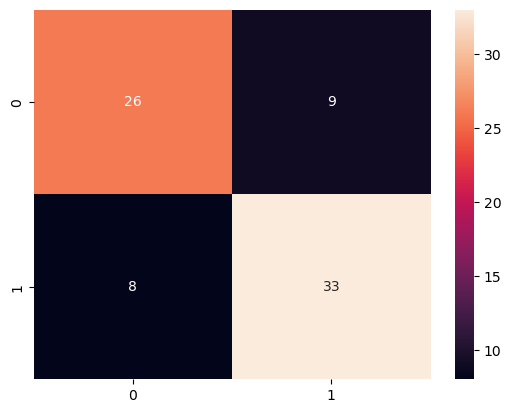

In [233]:
clf = KNeighborsClassifier(n_neighbors = 9, weights = 'uniform').fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))

Результаты хуже. При таком количестве соседей, как по мне, установление весом относительно дистанции - must have!

In [234]:
clf = KNeighborsClassifier(n_neighbors = 9, weights = 'distance').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76        35
           1       0.79      0.83      0.81        41

    accuracy                           0.79        76
   macro avg       0.79      0.79      0.79        76
weighted avg       0.79      0.79      0.79        76



По всем показателям лучше

In [235]:
clf = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        35
           1       0.83      0.85      0.84        41

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76



In [236]:
scores['knn'] = classification_report(y_test, y_pred)

При 5 соседях recall = 0.85, так получше. Но нужно учитывать, что результат получен не на CV, так что всё-таки лучше полагаться на гиперпараметры, полученные ч/з optuna.

## 7.4 Naive Bayes

In [ ]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
    
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", GaussianNB( 
            var_smoothing = var_smoothing
        ))
    ])
    score = cross_val_score(clf, features, targets, cv=stratified_cv, n_jobs=-1, scoring='roc_auc').mean()

    return score

study = optuna.create_study(study_name='NaiveBayes_study', direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 02:50:03,638] A new study created in memory with name: SVC_study
[I 2024-11-21 02:50:03,749] Trial 0 finished with value: 0.8698347608274078 and parameters: {'var_smoothing': 7.51201770688219e-09}. Best is trial 0 with value: 0.8698347608274078.
[I 2024-11-21 02:50:03,820] Trial 1 finished with value: 0.8698347608274078 and parameters: {'var_smoothing': 8.84635138196141e-07}. Best is trial 0 with value: 0.8698347608274078.
[I 2024-11-21 02:50:03,878] Trial 2 finished with value: 0.8698347608274078 and parameters: {'var_smoothing': 4.356638587114723e-07}. Best is trial 0 with value: 0.8698347608274078.
[I 2024-11-21 02:50:03,930] Trial 3 finished with value: 0.8698347608274078 and parameters: {'var_smoothing': 7.193394804757415e-09}. Best is trial 0 with value: 0.8698347608274078.
[I 2024-11-21 02:50:03,984] Trial 4 finished with value: 0.8698347608274078 and parameters: {'var_smoothing': 1.3399286183635407e-06}. Best is trial 0 with value: 0.8698347608274078.
[I 2024-11-2

Best trial:
  Values:  [0.8698347608274078]
  Params: 
    var_smoothing: 7.51201770688219e-09


              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.80      0.78      0.79        41

    accuracy                           0.78        76
   macro avg       0.78      0.78      0.78        76
weighted avg       0.78      0.78      0.78        76



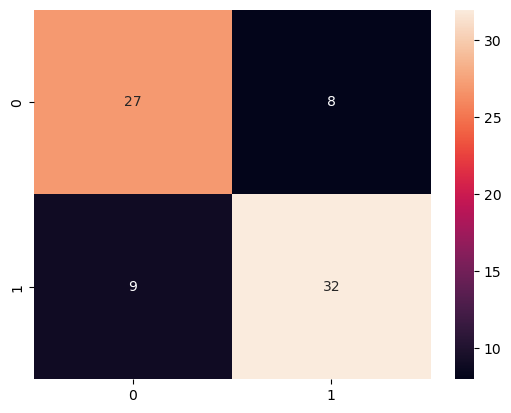

In [238]:
clf = GaussianNB(var_smoothing=7.5e-9).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))

Похуже, похуже... И на кросс-валидации 0.86 - самый низкий показатель. На то Байес и наивный

In [239]:
scores['naive_bayes'] = classification_report(y_test, y_pred)

## 7.5 DecisionTree

In [240]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 4, step=1)
    ccp_alpha = trial.suggest_float('ccp_float', 0, 1, step=1e-2)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            ccp_alpha=ccp_alpha
        ))
    ])
    score = cross_val_score(clf, features, targets, cv=stratified_cv, n_jobs=-1, scoring='roc_auc').mean()

    return score

study = optuna.create_study(study_name='DecisionTree_study', direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 02:57:33,683] A new study created in memory with name: DecisionTree_study
[I 2024-11-21 02:57:40,629] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'ccp_float': 0.87}. Best is trial 0 with value: 0.5.
[I 2024-11-21 02:57:40,713] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'ccp_float': 0.32}. Best is trial 0 with value: 0.5.
[I 2024-11-21 02:57:40,802] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'ccp_float': 0.78}. Best is trial 0 with value: 0.5.
[I 2024-11-21 02:57:40,891] Trial 3 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'ccp_float': 0.45}. Best is trial 0 with value: 0.5.
[I 2024-11-21 02:57:40,956] Trial 4 finis

Best trial:
  Values:  [0.866728951195863]
  Params: 
    criterion: gini
    max_depth: 3
    min_samples_split: 4
    min_samples_leaf: 2
    ccp_float: 0.02


              precision    recall  f1-score   support

           0       0.86      0.71      0.78        35
           1       0.79      0.90      0.84        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.81        76



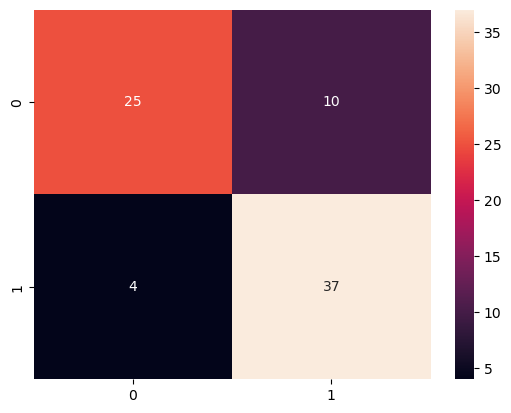

In [242]:
clf = DecisionTreeClassifier(criterion='gini',
            max_depth=3,
            min_samples_leaf=4,
            min_samples_split=2,
            ccp_alpha=0.02).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))

Решающее дерево по качеству показало себя на уровне логистической регрессиии и метода ближайших соседей.

In [243]:
scores['decision_tree'] = classification_report(y_test, y_pred)

## 7.6 Итоги по всем моделям

In [246]:
for method, info in scores.items():
    print(method)
    print(info)

svm
              precision    recall  f1-score   support

           0       0.90      0.74      0.81        35
           1       0.81      0.93      0.86        41

    accuracy                           0.84        76
   macro avg       0.85      0.83      0.84        76
weighted avg       0.85      0.84      0.84        76

knn
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        35
           1       0.83      0.85      0.84        41

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76

naive_bayes
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.80      0.78      0.79        41

    accuracy                           0.78        76
   macro avg       0.78      0.78      0.78        76
weighted avg       0.78      0.78      0.78        76


Хуже всего показал себя наивный байес, потом KNN, оставшиеся модели на похожем уровне сработали.
Сравнивая библиотечные методы и мои, мой SVM сработал ужасно (возможно, ошибка в имплементации), а вот дерево решений сработало на сходном уровне с библиотечными (по крайней мере, не хуже Байеса)

# 10. Повторение всех задач на новых данных
Набор данных UCI Adult: классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более $ 50 000 в год.

Описание признаков:

Age – возраст, количественный признак

Workclass – тип работодателя, количественный признак

fnlwgt – итоговый вес обьекта, количественный признак

Education – уровень образования, качественный признак

Education_Num – количество лет обучения, количественный признак

Martial_Status – семейное положение, категориальный признак

Occupation – профессия, категориальный признак

Relationship – тип семейных отношений, категориальный признак

Race – раса, категориальный признак

Sex – пол, качественный признак

Capital_Gain – прирост капитала, количественный признак

Capital_Loss – потери капитала, количественный признак

Hours_per_week – количество часов работы в неделю, количественный признак

Country – страна, категориальный признак

**Целевая переменная**: Target – уровень заработка, категориальный (бинарный) признак

In [86]:
df2 = pl.read_csv('adult_data.csv')

## 10.1 EDA

In [87]:
df2.shape

(32561, 15)

In [88]:
df2.unique()

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
i64,str,i64,str,i64,str,str,str,str,str,i64,i64,i64,str,str
32,"""Private""",188048,"""Bachelors""",13,"""Never-married""","""Adm-clerical""","""Own-child""","""White""","""Female""",0,0,40,"""United-States""","""<=50K"""
22,"""State-gov""",48121,"""Some-college""",10,"""Married-civ-spouse""","""Other-service""","""Husband""","""White""","""Male""",0,0,25,"""United-States""","""<=50K"""
33,"""Federal-gov""",122220,"""Some-college""",10,"""Married-civ-spouse""","""Exec-managerial""","""Wife""","""Black""","""Female""",0,0,40,"""United-States""",""">50K"""
53,"""Private""",231919,"""HS-grad""",9,"""Married-civ-spouse""","""Machine-op-inspct""","""Husband""","""White""","""Male""",0,0,45,"""United-States""","""<=50K"""
23,"""Private""",179423,"""Bachelors""",13,"""Never-married""","""Adm-clerical""","""Not-in-family""","""White""","""Female""",0,0,5,"""United-States""","""<=50K"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
37,"""Private""",161141,"""Assoc-voc""",11,"""Married-civ-spouse""","""Craft-repair""","""Husband""","""White""","""Male""",0,0,40,"""Portugal""",""">50K"""
47,"""Private""",220124,"""HS-grad""",9,"""Never-married""","""Craft-repair""","""Not-in-family""","""White""","""Male""",0,0,40,"""United-States""","""<=50K"""
29,"""Private""",152951,"""HS-grad""",9,"""Married-civ-spouse""","""Craft-repair""","""Husband""","""White""","""Male""",0,0,40,"""United-States""",""">50K"""


Есть несколько дубликатов. Удаляем

In [89]:
df2 = df2.unique()

In [90]:
# Кодируем target-переменную
df2 = df2.with_columns(
    pl.when(pl.col("salary") == "<=50K").then(0).otherwise(1).alias("salary").cast(pl.Int64)
)

<Axes: >

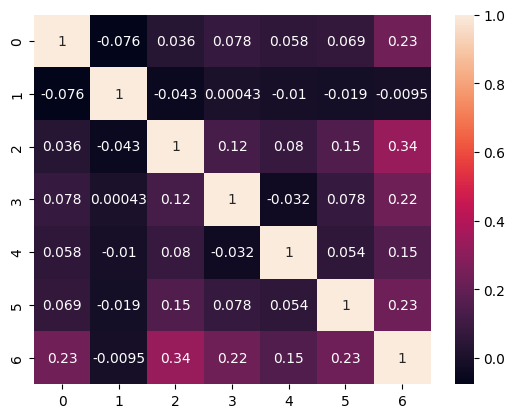

In [91]:
num_cols = df2.select(pl.col(pl.Int64, pl.Float64)).columns
sns.heatmap(df2.select(num_cols).corr(), annot=True)

Корреляции, по крайней мере, между числовыми признаками, нет

In [92]:
str_cols = df2.select(pl.col(pl.String)).columns

df2 = df2.with_columns(
    df2.select(pl.col(pl.String)).to_dummies()
)

# Удаляем по одному столбцу из закодированных столбцов
str_cols.extend(['workclass_?', 'education_10th', 'native-country_Cuba',
                'race_Amer-Indian-Eskimo', 'marital-status_Divorced', 'occupation_?'])
df2 = df2.drop(str_cols)

In [93]:
df2.select(num_cols).describe()

statistic,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary
str,f64,f64,f64,f64,f64,f64,f64
"""count""",32537.0,32537.0,32537.0,32537.0,32537.0,32537.0,32537.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",38.585549,189780.848511,10.081815,1078.443741,87.368227,40.440329,0.240926
"""std""",13.637984,105556.471009,2.571633,7387.957424,403.101833,12.346889,0.427652
"""min""",17.0,12285.0,1.0,0.0,0.0,1.0,0.0
"""25%""",28.0,117827.0,9.0,0.0,0.0,40.0,0.0
"""50%""",37.0,178356.0,10.0,0.0,0.0,40.0,0.0
"""75%""",48.0,236993.0,12.0,0.0,0.0,45.0,0.0
"""max""",90.0,1.484705e6,16.0,99999.0,4356.0,99.0,1.0


<Axes: >

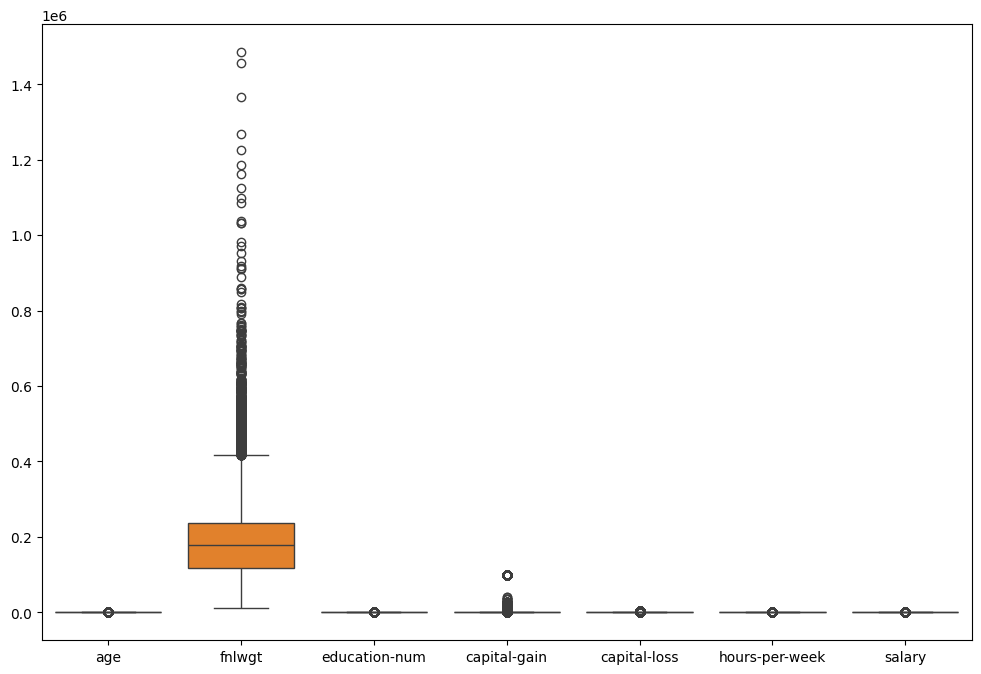

In [94]:
plt.figure(figsize=(12,8))
sns.boxplot(df2.select(num_cols).to_pandas())

Выбросов много. Сначала разберёмся с fnlwgt

<Axes: ylabel='Count'>

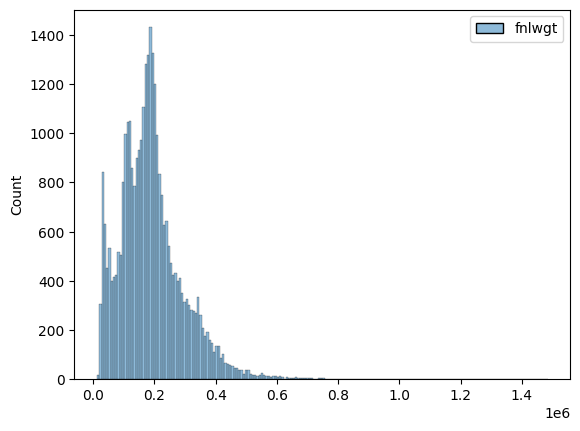

In [95]:
# И не нормальное, и не логнормальное
sns.histplot(df2.select('fnlwgt').to_pandas())

In [96]:
df2 = df2.filter(df2['fnlwgt'] < np.percentile(df2['fnlwgt'], 95))

<Axes: >

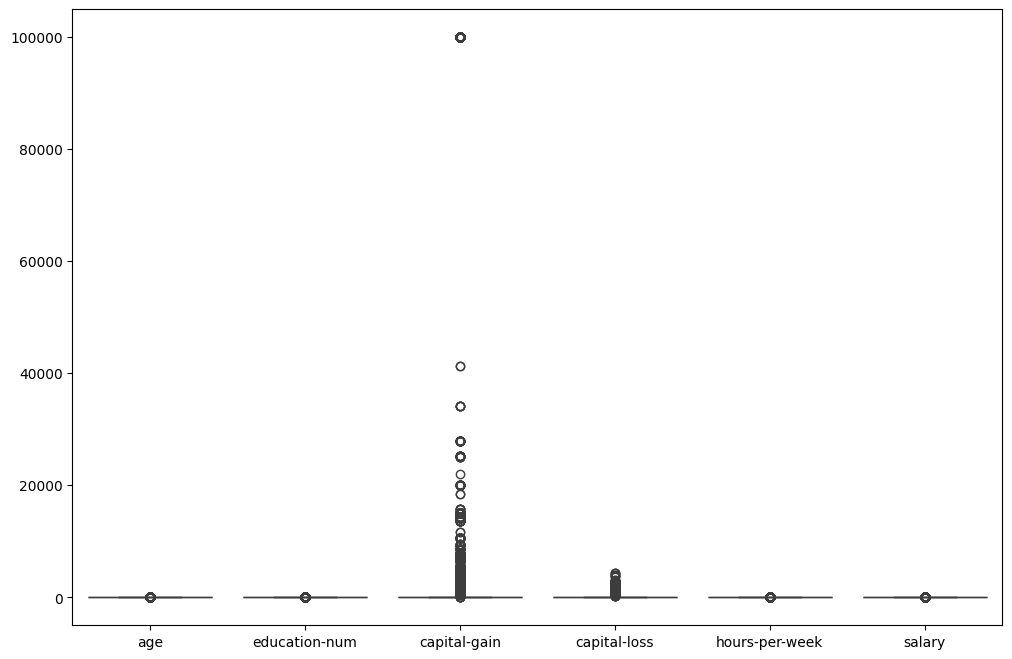

In [97]:
plt.figure(figsize=(12,8))
sns.boxplot(df2.select(num_cols).drop('fnlwgt').to_pandas())

In [98]:
df2 = df2.filter(df2['capital-gain'] < np.percentile(df2['capital-gain'], 97.5))

<Axes: >

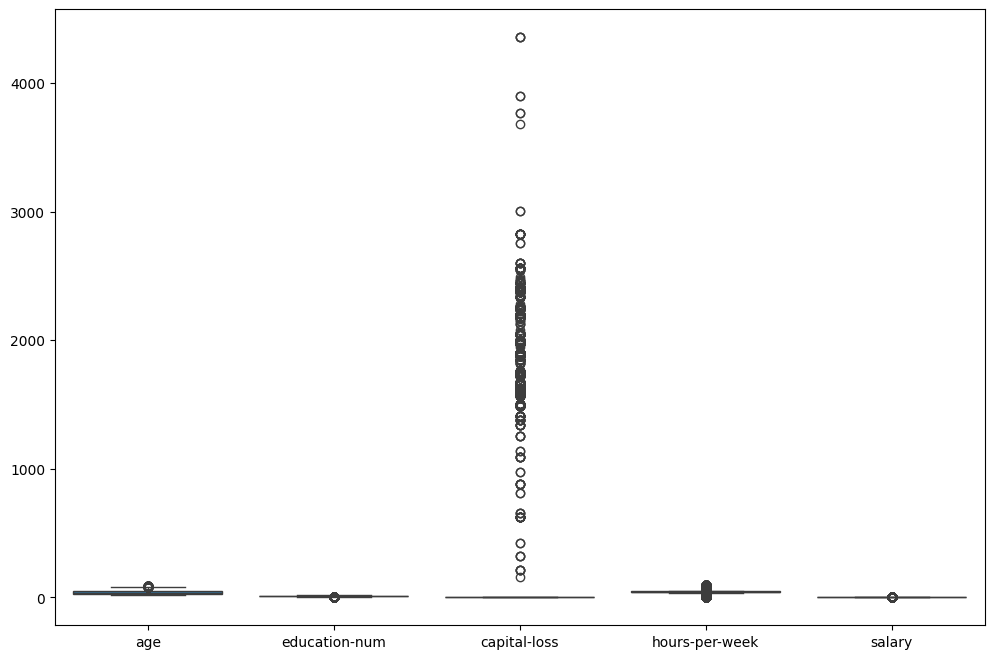

In [99]:
plt.figure(figsize=(12,8))
sns.boxplot(df2.select(num_cols).drop(['fnlwgt', 'capital-gain']).to_pandas())

In [100]:
df2 = df2.filter(df2['capital-loss'] < np.percentile(df2['capital-loss'], 97.5))

<Axes: >

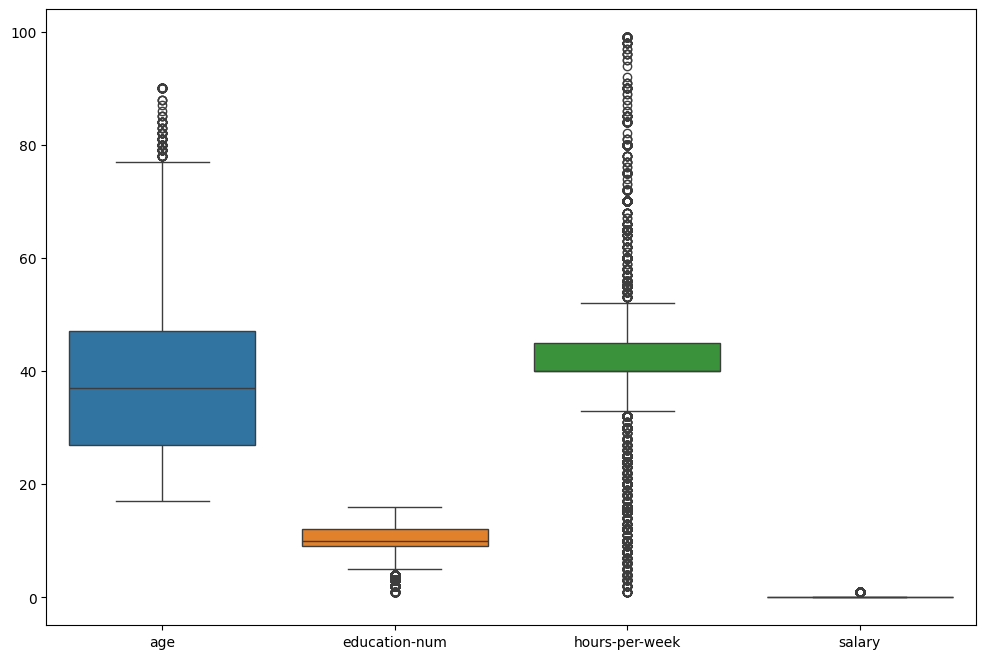

In [101]:
plt.figure(figsize=(12,8))
sns.boxplot(df2.select(num_cols).drop(['fnlwgt', 'capital-gain', 'capital-loss']).to_pandas())

In [102]:
df2 = df2.filter(df2['hours-per-week'] < np.percentile(df2['hours-per-week'], 98))
df2 = df2.filter(df2['hours-per-week'] > np.percentile(df2['hours-per-week'], 2))

Работа с выбросами закончена.

In [103]:
df2

age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,…,native-country_Columbia,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
i64,i64,i64,i64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
45,168232,13,0,0,55,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19,174233,10,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43,260960,13,0,0,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
64,289741,10,0,0,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
36,103110,16,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
55,189933,6,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
38,279315,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
33,121966,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


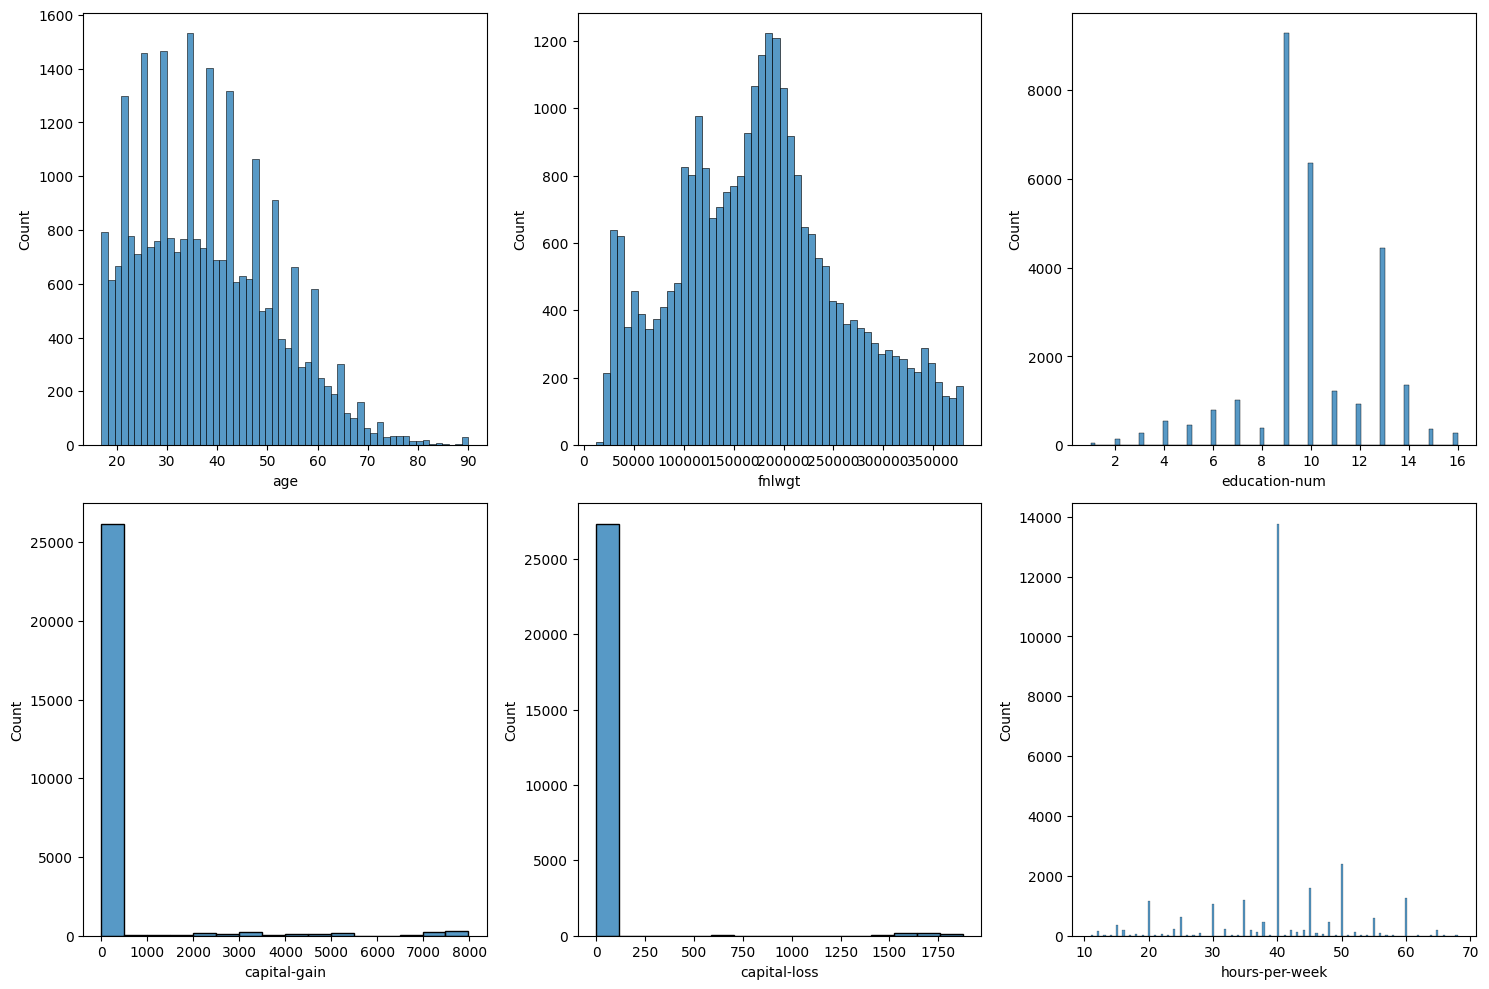

In [104]:
df_pandas = df2.select(num_cols).to_pandas()

n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if i == len(num_cols) - 1:
        break
    sns.histplot(df_pandas[col], ax=axes[i], kde=False)
    axes[i].set_xlabel(col)

for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Не так плохо. И fnlwgt приблизилось к нормальному распределению

In [105]:
targets = df2['salary']
features = df2.drop('salary')

In [106]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, shuffle=True, stratify=targets)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 10.2 Проверка имплементированных методов

In [80]:
scores = {}

### 10.2.1 SVM

In [81]:
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'rbf'])
    C = trial.suggest_float("C", 0.001, 10.0, step=1)
    gamma = trial.suggest_float("gamma", 0.001, 5, step=0.1)

    clf = MySVM(
            X=X_train,
            y=y_train,
            kernel = kernel,
            C=C, 
            gamma=gamma
    )
    
    clf.fit()

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)

    return score

study = optuna.create_study(study_name='SVC_study', direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 17:54:16,086] A new study created in memory with name: SVC_study
c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.001, 10.0] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 9.001].
  warnings.warn(
c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.001, 5] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.001, 4.901].
  warnings.warn(
[I 2024-11-21 17:54:37,904] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'linear', 'C': 1.001, 'gamma': 2.601}. Best is trial 0 with value: 0.5.
c:\Users\Maksim\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.001, 10.0] and step=1, but the range is not divisible by `step`. It

KeyboardInterrupt: 

In [82]:
svm = MySVM(X_train, y_train, C=7.0, kernel='rbf', gamma=0.7)
svm.fit()
y_pred = svm.predict(X_test)
roc_auc_score(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

C:\Users\Maksim\AppData\Local\Temp\ipykernel_8288\3684780346.py:114: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return 0.5 * np.sum(


KeyboardInterrupt: 

P.S: к сожалению, функция оказалась непригодна для такого большого датасета. Возможно, проблема в имплементации, либо нужно улучшать метод с помощью различных оптимизаций. В нынешнем состоянии она непригодна

Хотя вцелом я не удивляюсь, ввиду сложности формул. Вроде как, нелинейные ядра и так сложны для расчёта, а на больших датасетах и без оптимизации это особенно трудно сделать.

### 10.2.2 DecisionTree

In [83]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 4, step=1)

    clf = MyDecisionTree(
            max_depth=max_depth,
            min_samples_split=min_samples_split
        )
    
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)
    return score

study = optuna.create_study(study_name='DecisionTree_study', direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 19:27:05,226] A new study created in memory with name: DecisionTree_study
[I 2024-11-21 19:27:34,486] Trial 0 finished with value: 0.7294196344931488 and parameters: {'max_depth': 9, 'min_samples_split': 2}. Best is trial 0 with value: 0.7294196344931488.
[I 2024-11-21 19:28:06,182] Trial 1 finished with value: 0.7209916051139242 and parameters: {'max_depth': 10, 'min_samples_split': 4}. Best is trial 0 with value: 0.7294196344931488.
[I 2024-11-21 19:28:37,415] Trial 2 finished with value: 0.7207197674915973 and parameters: {'max_depth': 10, 'min_samples_split': 3}. Best is trial 0 with value: 0.7294196344931488.
[I 2024-11-21 19:28:55,889] Trial 3 finished with value: 0.7116500712518489 and parameters: {'max_depth': 6, 'min_samples_split': 3}. Best is trial 0 with value: 0.7294196344931488.
[I 2024-11-21 19:29:24,157] Trial 4 finished with value: 0.7291651814714676 and parameters: {'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.7294196344931488.


Best trial:
  Values:  [0.7294196344931488]
  Params: 
    max_depth: 9
    min_samples_split: 2


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5518
           1       0.71      0.51      0.60      1449

    accuracy                           0.85      6967
   macro avg       0.79      0.73      0.75      6967
weighted avg       0.84      0.85      0.85      6967



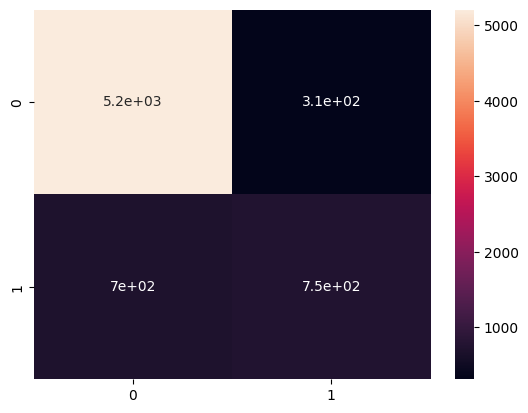

In [84]:
tree = MyDecisionTree(max_depth=9, min_samples_split=2)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
roc_auc_score(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))

Качество оставляет желать лучшего..

## 10.3 Проверка библиотечных методов

### 10.3.1 Logistic regression

In [25]:
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ['l1', 'l2', None])
    C = trial.suggest_float("C", 1e-5, 10.0, step=1)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            penalty=penalty, 
            C=C,
            solver='saga', 
            max_iter=1000
        ))
    ])

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)

    return score

study = optuna.create_study(study_name='logreg_study', direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 15:44:37,104] A new study created in memory with name: logreg_study
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.00001].
  warnings.warn(
[I 2024-11-21 15:45:24,467] Trial 0 finished with value: 0.7324072218882878 and parameters: {'penalty': 'l1', 'C': 7.00001}. Best is trial 0 with value: 0.7324072218882878.
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.00001].
  warnings.warn(
[I 2024-11-21 15:45:54,134] Trial 1 finished with value: 0.7324072218882878 and parameters: {'penalty': 'l2', 'C': 2.00001}. Best is trial 0 with value: 0.7324072218882878.
C:\Users\Maksim\AppData\Roaming\Python\Pytho

Best trial:
  Values:  [0.7324072218882878]
  Params: 
    penalty: l1
    C: 7.00001


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5518
           1       0.68      0.53      0.60      1449

    accuracy                           0.85      6967
   macro avg       0.78      0.73      0.75      6967
weighted avg       0.84      0.85      0.84      6967



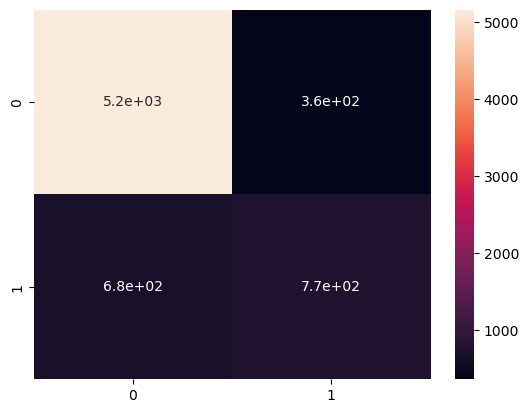

In [28]:
clf = LogisticRegression(penalty='l1', C=7, solver='saga').fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))
scores['logreg'] = classification_report(y_test, y_pred)

Ну так себе результаты. Бедных угадываем, богатых не угадываем.

### 10.3.2 SVM

In [29]:
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['poly', 'rbf'])
    degree = 1
    coef0 = 0.0
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5, step=1)
        coef0 = trial.suggest_float('coef0', 0.0, 1.0, step = 0.1)

    C = trial.suggest_float("C", 1e-5, 10.0, step=5e-1)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC( 
            C = C, 
            degree = degree, 
            coef0 = coef0,
            max_iter = -1
        ))
    ])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)

    return score

study = optuna.create_study(study_name='SVC_study', direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 15:52:20,986] A new study created in memory with name: SVC_study
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.5, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.50001].
  warnings.warn(
[I 2024-11-21 15:53:36,294] Trial 0 finished with value: 0.7291130276695306 and parameters: {'kernel': 'rbf', 'C': 6.00001}. Best is trial 0 with value: 0.7291130276695306.
C:\Users\Maksim\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [1e-05, 10.0] and step=0.5, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.50001].
  warnings.warn(
[I 2024-11-21 15:54:34,840] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'poly', 'degree': 5, 'coef0': 0.0, 'C': 1e-05}. Best is trial 0 with value: 0.7291130276695306.
C:\Users\Maksim\AppData\Roaming\

Best trial:
  Values:  [0.7291130276695306]
  Params: 
    kernel: rbf
    C: 6.00001


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5518
           1       0.70      0.52      0.59      1449

    accuracy                           0.85      6967
   macro avg       0.79      0.73      0.75      6967
weighted avg       0.84      0.85      0.84      6967



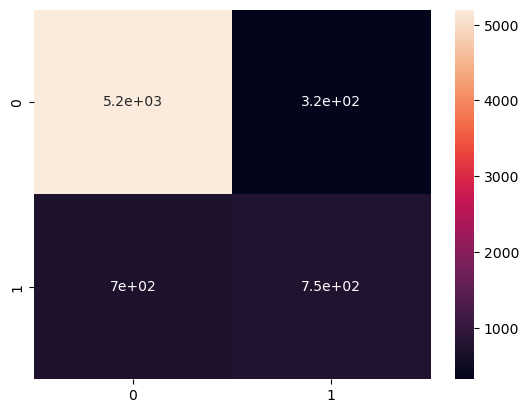

In [33]:
clf = SVC(kernel='rbf', C=6).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test,y_pred))
scores['svm'] = classification_report(y_test, y_pred)

SVM сработал на сходном с логистической регрессией уровне

### 10.3.3 KNN

In [30]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 5, step=1)
    weights = 'distance'

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier( 
            n_neighbors = n_neighbors, 
            weights = weights
        ))
    ])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)

    return score

study = optuna.create_study(study_name='KNN_study', direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 16:03:54,126] A new study created in memory with name: KNN_study
[I 2024-11-21 16:03:55,936] Trial 0 finished with value: 0.7233791736486476 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.7233791736486476.
[I 2024-11-21 16:03:57,303] Trial 1 finished with value: 0.7217618429777845 and parameters: {'n_neighbors': 4}. Best is trial 0 with value: 0.7233791736486476.
[I 2024-11-21 16:03:58,711] Trial 2 finished with value: 0.7217618429777845 and parameters: {'n_neighbors': 4}. Best is trial 0 with value: 0.7233791736486476.
[I 2024-11-21 16:04:00,187] Trial 3 finished with value: 0.7233791736486476 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.7233791736486476.
[I 2024-11-21 16:04:01,594] Trial 4 finished with value: 0.7071310756365203 and parameters: {'n_neighbors': 2}. Best is trial 0 with value: 0.7233791736486476.


Best trial:
  Values:  [0.7233791736486476]
  Params: 
    n_neighbors: 3


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5518
           1       0.56      0.56      0.56      1449

    accuracy                           0.82      6967
   macro avg       0.72      0.72      0.72      6967
weighted avg       0.82      0.82      0.82      6967



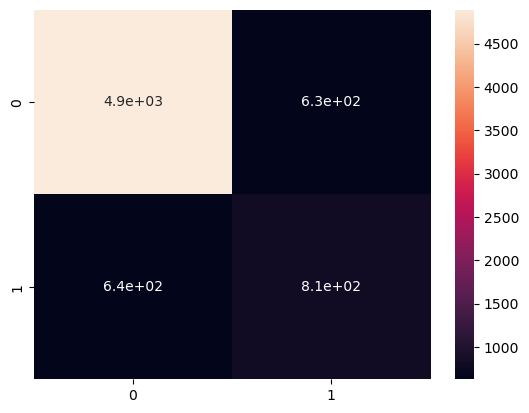

In [34]:
clf = KNeighborsClassifier(n_neighbors = 3, weights = 'distance').fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))
scores['knn'] = classification_report(y_test, y_pred)

В среднем, качество то же. Но модель ближайших соседей лучше угадывает "богатых" и реже "бедных". В противовес для какого-нибудь ансамбля может и сойти.

### 10.3.4 Naive Bayes

In [31]:
def objective(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
    
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", GaussianNB( 
            var_smoothing = var_smoothing
        ))
    ])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    score = roc_auc_score(y_test, y_pred)

    return score

study = optuna.create_study(study_name='NaiveBayes_study', direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 16:04:01,626] A new study created in memory with name: NaiveBayes_study
[I 2024-11-21 16:04:01,827] Trial 0 finished with value: 0.6528438455136849 and parameters: {'var_smoothing': 1.6486685824311363e-07}. Best is trial 0 with value: 0.6528438455136849.
[I 2024-11-21 16:04:02,001] Trial 1 finished with value: 0.6298145650935729 and parameters: {'var_smoothing': 1.3614592748482324e-08}. Best is trial 0 with value: 0.6528438455136849.
[I 2024-11-21 16:04:02,156] Trial 2 finished with value: 0.6574440109550499 and parameters: {'var_smoothing': 4.295373198704068e-07}. Best is trial 2 with value: 0.6574440109550499.
[I 2024-11-21 16:04:02,336] Trial 3 finished with value: 0.6648531651604599 and parameters: {'var_smoothing': 2.016145521183822e-06}. Best is trial 3 with value: 0.6648531651604599.
[I 2024-11-21 16:04:02,524] Trial 4 finished with value: 0.6008743953848513 and parameters: {'var_smoothing': 1.149234089214941e-09}. Best is trial 3 with value: 0.6648531651604599.
[I

Best trial:
  Values:  [0.6648531651604599]
  Params: 
    var_smoothing: 2.016145521183822e-06


              precision    recall  f1-score   support

           0       0.97      0.37      0.54      5518
           1       0.29      0.96      0.44      1449

    accuracy                           0.49      6967
   macro avg       0.63      0.66      0.49      6967
weighted avg       0.83      0.49      0.52      6967



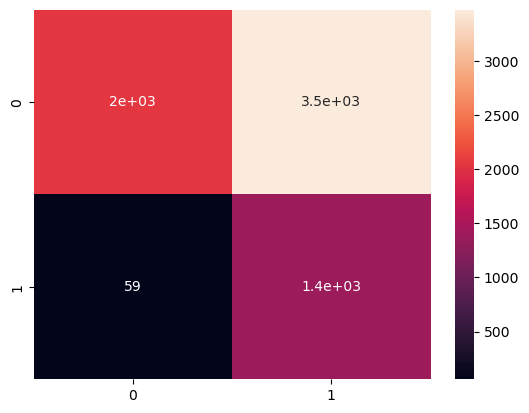

In [35]:
clf = GaussianNB(var_smoothing=2e-6).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))
scores['naive_bayes'] = classification_report(y_test, y_pred)

Очень интересные результаты. Модель выявила почти всех богачей, а вот с бедными не справилась от слова совсем

### 10.3.5 Decision Tree

In [ ]:
def objective(trial):
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 4, step=1)
    ccp_alpha = trial.suggest_float('ccp_float', 0, 1, step=1e-2)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            ccp_alpha=ccp_alpha
        ))
    ])
    score = cross_val_score(clf, features, targets, cv=stratified_cv, n_jobs=-1, scoring='roc_auc').mean()

    return score

study = optuna.create_study(study_name='DecisionTree_study', direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
trial = study.best_trial

print("  Values: ", trial.values)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-21 16:04:03,377] A new study created in memory with name: DecisionTree_study
[I 2024-11-21 16:04:03,760] Trial 0 finished with value: 0.5 and parameters: {'max_depth': 6, 'ccp_float': 0.7000000000000001}. Best is trial 0 with value: 0.5.
[I 2024-11-21 16:04:03,990] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 4, 'ccp_float': 0.2}. Best is trial 0 with value: 0.5.
[I 2024-11-21 16:04:04,357] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 8, 'ccp_float': 0.1}. Best is trial 0 with value: 0.5.
[I 2024-11-21 16:04:04,681] Trial 3 finished with value: 0.5 and parameters: {'max_depth': 5, 'ccp_float': 0.7000000000000001}. Best is trial 0 with value: 0.5.
[I 2024-11-21 16:04:05,026] Trial 4 finished with value: 0.5 and parameters: {'max_depth': 7, 'ccp_float': 0.4}. Best is trial 0 with value: 0.5.
[I 2024-11-21 16:04:05,473] Trial 5 finished with value: 0.5 and parameters: {'max_depth': 9, 'ccp_float': 1.0}. Best is trial 0 with value: 0.5.
[I 202

Best trial:
  Values:  [0.7105553416874469]
  Params: 
    max_depth: 9
    ccp_float: 0.0


Что-то перебор по глубине

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5518
           1       0.70      0.40      0.51      1449

    accuracy                           0.84      6967
   macro avg       0.78      0.68      0.71      6967
weighted avg       0.82      0.84      0.82      6967



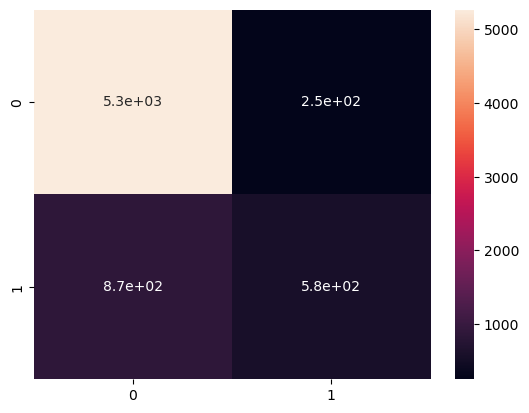

In [36]:
clf = DecisionTreeClassifier(criterion='gini',
            max_depth=9,
            min_samples_leaf=4,
            min_samples_split=2,
            ccp_alpha=0.02).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))
scores['decision_tree'] = classification_report(y_test, y_pred)

Откровенно посредственный результат. Может по средней метрике модель и показала себя лучше, чем наивный байес, но при ближайшем рассмотрении, она неплохо себя показала на "0" классе, но хуже, чем Байес на "1". Скорее всего проблема в предложенной optuna глубине, это же приводит к очевидному переобучению.

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5518
           1       0.69      0.45      0.54      1449

    accuracy                           0.84      6967
   macro avg       0.78      0.70      0.72      6967
weighted avg       0.83      0.84      0.83      6967



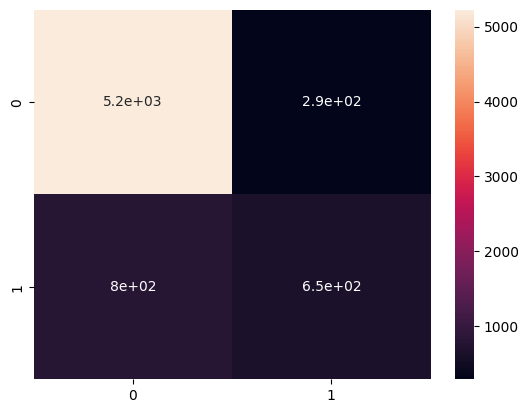

In [123]:
clf = DecisionTreeClassifier(criterion='gini',
            max_depth=4,
            min_samples_leaf=2,
            min_samples_split=2,
            ccp_alpha=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))
scores['decision_tree'] = classification_report(y_test, y_pred)

Получилось добиться чуть лучшего качества, но не сильно. Видимо классы очень тяжело разделимы и решающее дерево наоборот плохо обобщает, даже хуже, чем линейные параметрические модели.

### 10.3.6 Общий вывод

В общем и целом, если использовать модели в мягком ансамблировании, то может и толк из этого выйдет. Но если по существу, данные видимо оказались слишком трудны для простых моделей и зачастую они работают ну так себе.